### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개의 Feature 사용
- 구현프레임워크 : Pytorch

[1] 모듈 로딩 및 데이터 준비

In [196]:
## 모듈 로딩
import torch                        # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn               # 인공신경망 관련 모듈
import torch.nn.functional as F     # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer     # 최적화 기법 관련 모듈
import pandas as pd

from sklearn.model_selection import train_test_split

from torchmetrics.regression import R2Score # 성능 지표 관련 모듈 - 추가설치
from torchinfo import summary # 모델 정보 관련 모듈  - 추가설치

In [197]:
# 모델의 가중치 및 절편 값 고정 설정
torch.manual_seed(1)

# 저장 및 실행 위치 설정
DEVICE='cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE : {DEVICE}')

DEVICE : cpu


In [198]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE='../../MachineLearning/data/iris.csv'

irisDF=pd.read_csv(DATA_FILE,usecols=[0,1,2,3])
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [199]:
# 모델설계
# 입력층에 입력값/ 피쳐 : 3개
# 출력층에 출력값/타겟  : petal.width 1개
# 입력층 :  입력 피쳐 3,     출력 입력층에 존재하는 퍼셉트론 개수 10, 
#            ________________|               
#   AF :    |      ReLU
#           V
# 은닉층 :  입력 10,         출력 입력층에 존재하는 퍼셉트론 개수 5, 
#            ________________|               
#   AF :    |      ReLU
#           V
# 출력층 :  입력 5           
#           출력 타겟/라벨 개수1 
model=nn.Sequential(nn.Linear(3,10),
                    nn.ReLU(),
                    nn.Linear(10,5),
                    nn.ReLU(),
                    nn.Linear(5,1)) 

In [200]:
# 모델 구조 확인
print(model)

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=5, bias=True)
  (3): ReLU()
  (4): Linear(in_features=5, out_features=1, bias=True)
)


In [201]:
summary(model,input_size=(3,))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1]                       --
├─Linear: 1-1                            [10]                      40
├─ReLU: 1-2                              [10]                      --
├─Linear: 1-3                            [5]                       55
├─ReLU: 1-4                              [5]                       --
├─Linear: 1-5                            [1]                       6
Total params: 101
Trainable params: 101
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [202]:
# 가중치와 졀편 확인
for name, param in model.named_parameters():
    print(f'[{name}],{param}')

[0.weight],Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119],
        [ 0.2710, -0.5435,  0.3462],
        [-0.1188,  0.2937,  0.0803],
        [-0.0707,  0.1601,  0.0285],
        [ 0.2109, -0.2250, -0.0421],
        [-0.0520,  0.0837, -0.0023],
        [ 0.5047,  0.1797, -0.2150],
        [-0.3487, -0.0968, -0.2490],
        [-0.1850,  0.0276,  0.3442],
        [ 0.3138, -0.5644,  0.3579]], requires_grad=True)
[0.bias],Parameter containing:
tensor([ 0.1613,  0.5476,  0.3811, -0.5260, -0.5489, -0.2785,  0.5070, -0.0962,
         0.2471, -0.2683], requires_grad=True)
[2.weight],Parameter containing:
tensor([[ 0.3103, -0.1338,  0.2371,  0.0037, -0.1666,  0.1625, -0.1679,  0.0930,
         -0.0913, -0.0347],
        [-0.3040, -0.1508,  0.1716, -0.0769,  0.3150,  0.2535, -0.0148, -0.2111,
          0.1926,  0.0981],
        [-0.2044,  0.2054,  0.1920,  0.2805, -0.1773, -0.0521, -0.0061,  0.0462,
         -0.2400, -0.2244],
        [ 0.1720, -0.0742,  0.1545,  0.0180,  0.1038,  0.0

[3] 최적화 인스턴스 준비

In [203]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_opti=optimizer.Adam(model.parameters(),lr=0.1)

[4] 학습 ==> 개발자가 구현
- [4-1] 데이터셋 Tensor화 진행 : 데이터준비 시 진행하거나 학습 전 진행

In [204]:
featureDF=irisDF[irisDF.columns[:-1]]     ## 2D가 필요하므로 데이터 프레임으로 받아야함
featureDF.shape

(150, 3)

In [205]:
targetDF=irisDF[['petal.width']]
targetDF.shape

(150, 1)

In [206]:
# Train & Test
X_train,X_test,y_train,y_test=train_test_split(featureDF,targetDF,
                                               test_size=0.2,random_state=10)

# Train & Valid
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,
                                             test_size=0.2,random_state=10)

print(f'[Feature] Train {X_train.shape}, Val {X_val.shape}, Test {X_test.shape}')
print(f'[Target] Train {y_train.shape}, Val {y_val.shape}, Test {y_test.shape}')

[Feature] Train (96, 3), Val (24, 3), Test (30, 3)
[Target] Train (96, 1), Val (24, 1), Test (30, 1)


[4-2] 학습진행 
- 학습횟수 결정 ==> 에포크 설정
- 배치크기 결정
- 배치개수 계산

In [207]:
EPOCH=100                                  # 처음부터 끝까지 공부하는 횟수
BATCH_SIZE=10                               # 1 에포크에서 한번 학습할 분량 크기
BATCH_CNT=X_train.shape[0]//BATCH_SIZE      # 1 에포크에서 총 학습 횟수이면서 업데이트 횟수

print(f'EPOCH : {EPOCH}, BATCH_SIZE : {BATCH_SIZE}, BATCH_CNT : {BATCH_CNT}')

EPOCH : 100, BATCH_SIZE : 10, BATCH_CNT : 9


In [208]:
## 테스트/검증 함수
# ==> 가중치, 절편 업데이트x, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행행 
# 모델 학습 함수
def testing(test,test_target,kind='Val'):

    testTS=torch.FloatTensor(test.values).to(DEVICE)
    test_targetTS=torch.FloatTensor(test_target.values).to(DEVICE)
    with torch.no_grad():       # 가중치 및 절편 업데이트 진행 x
        #-(1) 학습진행 - forward
        pre_y=model(testTS)
        
        #-(2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y,test_targetTS)

        #-(3) 성능평가 - R2
        r2=R2Score()(pre_y,test_targetTS)
        
        
        #-(4) 학습결과 출력 및 저장 
        #print(f'[{kind}] Loss: {loss}')
    return loss.item(),r2
        

In [209]:
# 모델 학습 함수
def training(featureTS,targetTS,valTS,val_targetTS):
    
    loss_history=[[],[]]    # train,val
    r2_history=[[],[]]      # train,val


    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss=0
        bs_r2=0

        # 배치 크기 만큼 학습진행
        for i in range(BATCH_CNT):
            start=i*BATCH_SIZE
            end=start+BATCH_SIZE
            # print(start,end)

            # BS크기만큼만 데이터 추출해서 Tensor화 진행
            BSX_train=torch.FloatTensor(X_train[start:end].values).to(DEVICE)
            BSy_train=torch.FloatTensor(y_train[start:end].values).to(DEVICE)
            # print(BSX_train.shape,BSX_train.device)
            # print(BSy_train.shape,BSy_train.device)


            #-(1) 학습진행 - forward
            pre_y=model(BSX_train)
            
            #-(2) 오차계산 - 손실함수
            loss=F.mse_loss(pre_y,BSy_train)
            bs_loss+=loss.item()
            bs_r2+=R2Score()(pre_y,BSy_train).item()

            #-(3) 최적화 : 가중치, 절편 업데이트 - backward
            adam_opti.zero_grad()
            loss.backward()
            adam_opti.step()

        #-(4) 검증 : 모델이 잘 만들어진지 검사
        val_loss,val_r2=testing(valTS,val_targetTS)
        loss_history[1].append(val_loss)
        r2_history[1].append(val_r2)

        # 에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT)
        r2_history[0].append(bs_r2/BATCH_CNT)

        #-(4) 학습결과 출력 및 저장 
        print(f'[{epoch}/{EPOCH}] \n Train Loss: {loss_history[0][-1]} R2: {r2_history[0][-1]}')
        print(f'[{epoch}/{EPOCH}] \n Val Loss: {loss_history[1][-1]} R2: {r2_history[1][-1]}')
        
    return loss_history,r2_history
        

In [210]:
loss_list,r2_list=training(X_train,y_train,X_val,y_val)

[0/100] 
 Train Loss: 0.6369050840536753 R2: -0.44552720917595756
[0/100] 
 Val Loss: 0.4814639389514923 R2: 0.20410078763961792
[1/100] 
 Train Loss: 0.356249471505483 R2: 0.2564893364906311
[1/100] 
 Val Loss: 0.2876039445400238 R2: 0.524567186832428
[2/100] 
 Train Loss: 0.19377252873447207 R2: 0.5870092444949679
[2/100] 
 Val Loss: 0.10627926141023636 R2: 0.8243117332458496
[3/100] 
 Train Loss: 0.08622412300772136 R2: 0.810479031668769
[3/100] 
 Val Loss: 0.08336344361305237 R2: 0.8621934056282043
[4/100] 
 Train Loss: 0.07170399940676159 R2: 0.8377412623829312
[4/100] 
 Val Loss: 0.07717543095350266 R2: 0.8724226951599121
[5/100] 
 Train Loss: 0.0634142437742816 R2: 0.8582589824994405
[5/100] 
 Val Loss: 0.06531642377376556 R2: 0.8920266032218933
[6/100] 
 Train Loss: 0.059303120192554265 R2: 0.8699106176694235
[6/100] 
 Val Loss: 0.05975157022476196 R2: 0.9012258052825928
[7/100] 
 Train Loss: 0.05681685316893789 R2: 0.8770726256900363
[7/100] 
 Val Loss: 0.057578667998313904 R2

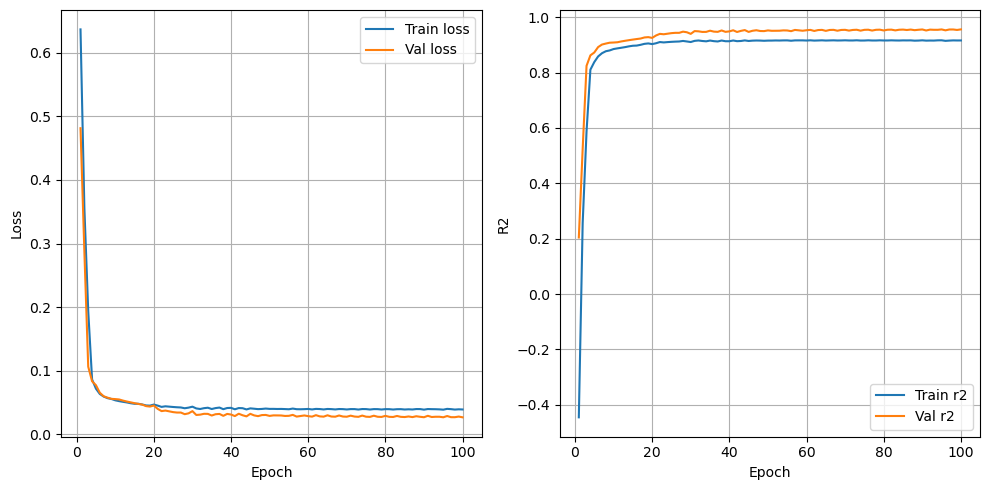

In [221]:
# 학습후 loss시각화
import matplotlib.pyplot as plt

fig,ax=plt.subplots(1,2,figsize=(10,5))

ax[0].plot(range(1,EPOCH+1),loss_list[0],label='Train loss')
ax[0].plot(range(1,EPOCH+1),loss_list[1],label='Val loss')
ax[0].grid()
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(range(1,EPOCH+1),r2_list[0],label='Train r2')
ax[1].plot(range(1,EPOCH+1),r2_list[1],label='Val r2')
ax[1].grid()
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('R2')
ax[1].legend()

plt.tight_layout()
plt.show()